# SVGP Demo

Simple demo running single layer Stochastic Variational Gaussian Process (SVGP).
Hensman, J., Matthews, A. and Ghahramani, Z., 2015. Scalable variational Gaussian process classification. Available at http://proceedings.mlr.press/v38/hensman15.pdf.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch import distributions

import kriggie as kg

rng = np.random.RandomState(56)

We first will set up a function to try to learn. We will sample points (with noise) for the GP to learn from.

In [2]:
def f_func(x_in):
    return np.sin(4.* x_in) + 1.5 * np.cos(6.*x_in) 

data_x = np.linspace(0., 2., 100).astype(kg.utils.NP_FLOAT_TYPE)
data_f = f_func(data_x).astype(kg.utils.NP_FLOAT_TYPE)


num_seen_points = 20
seen_x = rng.uniform(0., 2., size=num_seen_points).astype(kg.utils.NP_FLOAT_TYPE)
seen_y = (f_func(seen_x) + 0.2 * rng.randn(num_seen_points)).astype(kg.utils.NP_FLOAT_TYPE)
# ^ note we add independent noise to f to get observations.


Text(0, 0.5, 'y')

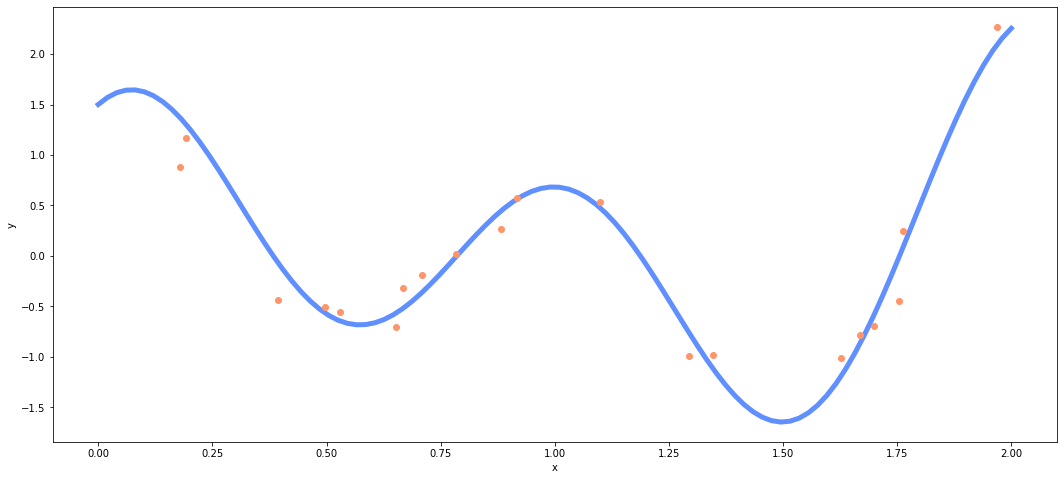

In [3]:
f, ax = plt.subplots(figsize=(18, 8))
ax.plot(data_x, data_f, color='#608fff', lw=5, label='function')
ax.plot(seen_x, seen_y, 'o', color='#ff956b', lw=5, label='observed')

ax.set_xlabel('x')
ax.set_ylabel('y')


We shall now setup the model. This consists of an SVGP layer with an assoicated Gaussian likelihood.

In [4]:
class SVGP(nn.Module):
    def __init__(self, num_inducing=10):
        super().__init__()
        # We will use a RBF kernel (also called Gaussian kernel or squared exponential):
        rbf_kern = kg.kernels.RBF(1)
        
        # You can "reset" (ie they are already given defaults) the initial hyperparameter values,
        # this is often easiest in the constrained space (for constrained hyperparameters) eg by:
        rbf_kern.ell.constrained_init_set(torch.tensor([0.5], dtype=kg.utils.TORCH_FLOAT_TYPE))
        
        # We then set up the SVGP layer.
        self.svgp = kg.SVGPLayer(rbf_kern, 1, num_inducing, 1)
        
        # We also reset the inducing point locations:
        with torch.no_grad():
            self.svgp.z_locations[...] = torch.linspace(0., 2., num_inducing, dtype=kg.utils.TORCH_FLOAT_TYPE)[:, None]

        # Finally we set up a value for the variance of the likelihood. This needs to be contrained to be positive:
        self.like_sigma_sq = kg.TransformedParam(torch.empty(1, dtype=kg.utils.TORCH_FLOAT_TYPE), transform=kg.SoftplusTransform())
        self.like_sigma_sq.constrained_init_set(torch.tensor([0.2], dtype=kg.utils.TORCH_FLOAT_TYPE))

    def forward(self, x_data, **kwargs):
        mean, var = self.svgp(x_data, **kwargs)
        return mean, var

    @property
    def kl(self):
        # convenience property for the underlying SVGP layer
        return self.svgp.summed_kl

    def clear_kl(self):
        # convenience function for the underlying SVGP layer
        self.svgp.clear_kl()
        
    def prob_int_qf_log_py(self, mean, var, target):
        return kg.custom_losses.log_gaussian_int_by_gaussian(mean, var, target, self.like_sigma_sq.constrained)

    def prob_marginals_y(self, mean, var):
        return mean, var + self.like_sigma_sq.constrained

svgp = SVGP()

We can now train the model!

In [5]:
optimizer = optim.Adam(svgp.parameters(), lr=0.01)
num_steps = 5000

seen_x_ten = torch.tensor(seen_x)[:, None]
seen_y_ten = torch.tensor(seen_y)[:, None]

for step in range(num_steps):
    # Each optimization step we need to clear the gradients and also the parameter which we use to store KL
    # divergences when we do a forward pass:
    optimizer.zero_grad()
    svgp.clear_kl()
    
    # We can now run forward and calculate the distribution at the seen points:
    mean, var = svgp(seen_x_ten)

    # We now need to form the two terms that make up our loss (the negative of the ELBO):
    # i. the negative log likelihood of the observations, ii. the KL divergence between the inducing point
    # distribution and the prior:
    var_expectation_term = svgp.prob_int_qf_log_py(mean, var, seen_y_ten).sum()
    neg_kl_term = svgp.kl
    loss = neg_kl_term + -var_expectation_term
    
    # We can now backpropagate and update the parameters!
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f"Step: {step}, loss: {loss.item()}")

# We can print out the final hyperparameter values (nb we also have parameters assoicated with the 
# variational distribution which you could print out if you wish).
print(f"Likelihood sigma  (squared): {svgp.like_sigma_sq.constrained}")
print(f"Kernel ell: {svgp.svgp.kernel.ell.constrained}")
print(f"Kernel sigma (squared) : {svgp.svgp.kernel.sigma_sq.constrained}")


Step: 0, loss: 141.0180206298828
Step: 100, loss: 28.71794891357422
Step: 200, loss: 23.761112213134766
Step: 300, loss: 21.333507537841797
Step: 400, loss: 20.459489822387695
Step: 500, loss: 19.104427337646484
Step: 600, loss: 18.167261123657227
Step: 700, loss: 17.26346778869629
Step: 800, loss: 16.391704559326172
Step: 900, loss: 15.590455055236816
Step: 1000, loss: 14.88526725769043
Step: 1100, loss: 14.318387031555176
Step: 1200, loss: 13.889912605285645
Step: 1300, loss: 13.598841667175293
Step: 1400, loss: 13.398397445678711
Step: 1500, loss: 13.261463165283203
Step: 1600, loss: 13.161128044128418
Step: 1700, loss: 13.081247329711914
Step: 1800, loss: 13.013017654418945
Step: 1900, loss: 12.950881958007812
Step: 2000, loss: 12.895683288574219
Step: 2100, loss: 12.857178688049316
Step: 2200, loss: 12.850173950195312
Step: 2300, loss: 12.791481971740723
Step: 2400, loss: 12.761007308959961
Step: 2500, loss: 12.727392196655273
Step: 2600, loss: 12.703718185424805
Step: 2700, loss:

Finally we will revisit the plot we made earlier. In addition to the underlying function we wish to learn we shall plot the learnt model's predictions (as well as some samples from this). We show the location of the inducing points as grey vertical lines.

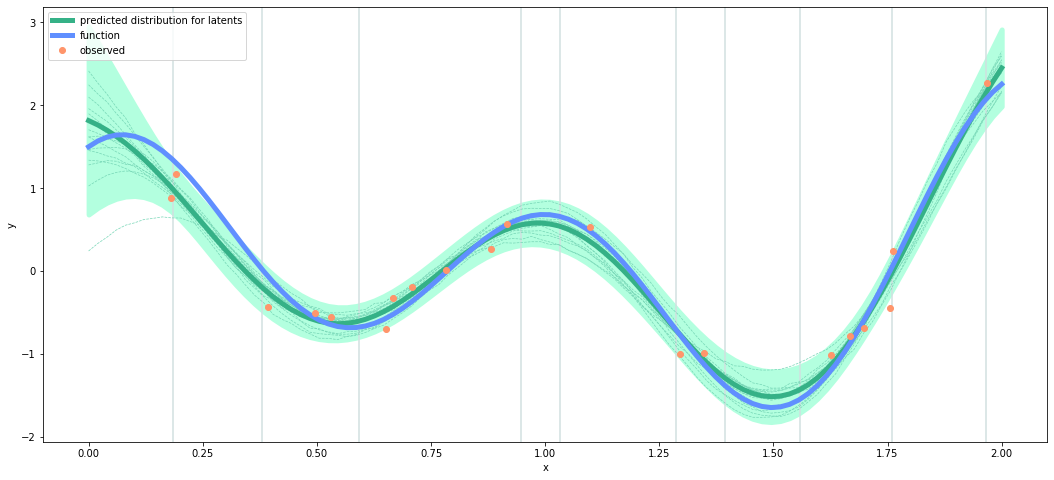

In [6]:
# First predict the mean and covariance with the observation noise over the entire x-axis
svgp.clear_kl()
mean_pred, var_f = svgp(torch.tensor(data_x[:, None]), marginals_only=True, latent_dim_last=False)
#mean_pred, var_y = svgp.prob_marginals_y(mean_pred, var_f)

# Set up the plot:
f, ax = plt.subplots(figsize=(18, 8))

# Draw the inducing point locations as grey vertical lines:
for incuding_pt in svgp.svgp.z_locations.detach().numpy().flatten():
    ax.axvline(incuding_pt, color='#d1e0e0')

# Next predict the mean and variance of the latent function over the latent space. Then use this to 
# draw samples from the posterior, these will be plotted as thinner dashed lines:
f_mean_pred, f_cov_mat = svgp.svgp(torch.tensor(data_x[:, None]), marginals_only=False, latent_dim_last=False)
cov_tril = kg.utils.try_func_with_increasing_jitter(lambda x: torch.cholesky(x, upper=False), f_cov_mat[0, ...], RuntimeError)
mvn_posterior = distributions.MultivariateNormal(f_mean_pred[0, :],
                     scale_tril=cov_tril)
samples = mvn_posterior.rsample(torch.Size([15])).detach().numpy()
for s in samples:
    ax.plot(data_x, s, '--', color='#76d6b6', lw=0.7)

# We shall now plot the predicted distribution. We shall do this by ploting the
# mean and 2 std deviations of the marginals (shaded) either side of the mean:
mn = mean_pred.detach().numpy().flatten()
std = torch.sqrt(var_f).detach().numpy().flatten()
ax.fill_between(data_x, mn + 2*std, mn - 2*std, color='#b3ffdf', lw=5)
ax.plot(data_x, mn, color='#35b187', lw=5, label='predicted distribution for latents')


# Finally we shall add the original function and the observed data:
ax.plot(data_x, data_f, color='#608fff', lw=5, label='function')
ax.plot(seen_x, seen_y, 'o', color='#ff956b', lw=5, label='observed')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()